# ИССЛЕДОВАНИЕ ДАННЫХ HR-АГЕНТСТВА

R-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

Исследуйте данные и сделайте выводы по полученным результатам. Подкрепите свои рассуждения и выводы визуализациями и с помощью статистического тестирования проверьте, являются ли выводы статистически значимыми.

В процессе анализа вы должны ответить на ключевые вопросы HR-агентства:

Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
Какие факторы влияют на зарплату у специалистов Data Scientist?
Как соотносятся зарплаты Data Scientist и Data Engineer в различных компаниях?
Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?
Если вы найдёте в данных интересные закономерности, также отметьте их в своём анализе.

Продемонстрируйте использование разных тестов для проверки статистической значимости сделанных выводов:

тесты для количественного признака:
для одной выборки;
для двух выборок;
для нескольких выборок;
тест для категориальных признаков.

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels import stats as sms
import seaborn as sns
import scipy.stats as stats
import matplotlib as plt


In [2]:
data=pd.read_csv('Data/ds_salaries.csv')
data.head()

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [6]:
# зададим уровень значимости на весь проект 
alpha=0.05
print('уровень значимости alpha= {:.2f}'.format(alpha))

уровень значимости alpha= 0.05


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


Пропуски не обнаружены

In [8]:
amount_of_duplicatess=data.duplicated().sum()
print(f'Всего дубликатов найдено: {amount_of_duplicatess}')

Всего дубликатов найдено: 0


In [50]:
data_about_DS=data[data['job_title']=='Data Scientist']


<Axes: xlabel='work_year', ylabel='salary_in_usd'>

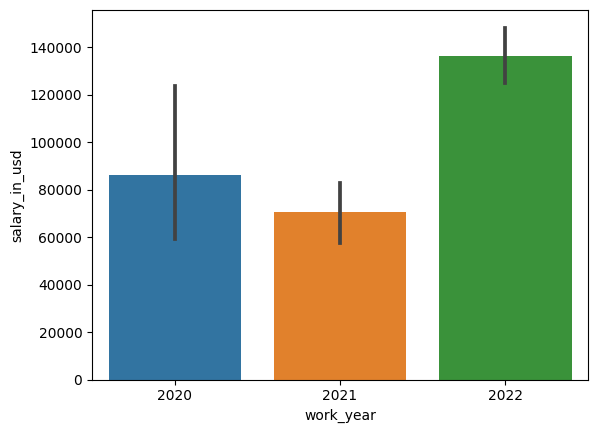

In [51]:
sns.barplot(data=data_about_DS,x='work_year',y='salary_in_usd')

Появляется предположение о том, что ЗП-шки действительно с каждым годом могут расти, а могут и не расти, непонятно в общем:( Но рост ЗП с каждым годом будет нашей альтернативной гипотезой, соответственно Н0 = зарплаты из года в год не меняюстя.

Создадим функцию, которая поможет найти ЗП для каждого года в отдельности и запишем в три новых датафрейма

In [43]:
def get_salary_of_year(df,year):
    df_salary=[]
    for elem in range(df.shape[0]):
        if df.iloc[elem]['work_year']==year and df.iloc[elem]['job_title']=='Data Scientist':
            df_salary.append(df.iloc[elem]['salary_in_usd'])
    return df_salary

salary_in_2020=get_salary_of_year(data,2020)
salary_in_2021=get_salary_of_year(data,2021)
salary_in_2022=get_salary_of_year(data,2022)

_, p2020 = stats.shapiro(salary_in_2020)
_, p2021 = stats.shapiro(salary_in_2021)
_, p2022 = stats.shapiro(salary_in_2022)

if p2020 <= alpha and p2021<=alpha and p2022<=alpha:
    print('Распределения не нормальные')
else:
    print('Распределениея нормальные')

Распределениея нормальные


Групп 3, они независимые, распределены нормално, значит...

# Используем ANOVA

In [47]:
print('Тест на равенство дисперсий')
result = stats.levene(salary_in_2020, salary_in_2021, salary_in_2022)
p = result[1]
print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('Дисперсии не одинаковы, нужно использовать непараметрический тест')
else:
    print('Дисперсии одинаковы, мы можем использовать тест ANOVA')

# проводим тест на сравнение средних в группах
print('\nТест на равенство средних')
_, p = stats.f_oneway(salary_in_2020, salary_in_2021, salary_in_2022)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))


Тест на равенство дисперсий
p-value = 0.832
Дисперсии одинаковы, мы можем использовать тест ANOVA

Тест на равенство средних
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


# Отвергаем нулевую гипотезу, значит в принципе ЗП растет с каждым годом !!!

<Axes: xlabel='company_size', ylabel='salary_in_usd'>

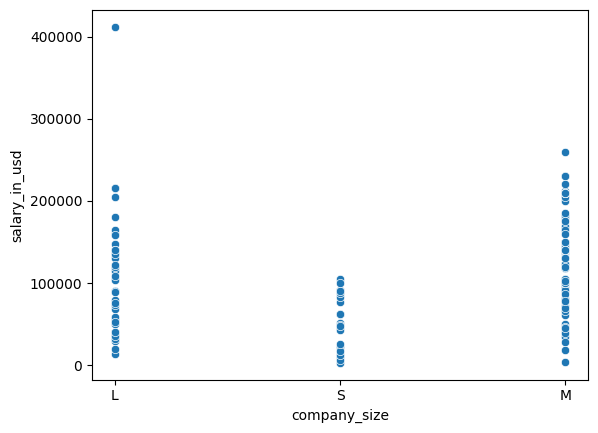

In [54]:
sns.scatterplot(data_about_DS,x='company_size',y='salary_in_usd')

очевидно, что в маленьких компаниях ЗП меньше, однако из-за хорошей ЗП в средних компаниях (по размеру) мы не можем сделать вывод о линейной зависимости размера компании и ЗП.

<Axes: xlabel='experience_level', ylabel='salary_in_usd'>

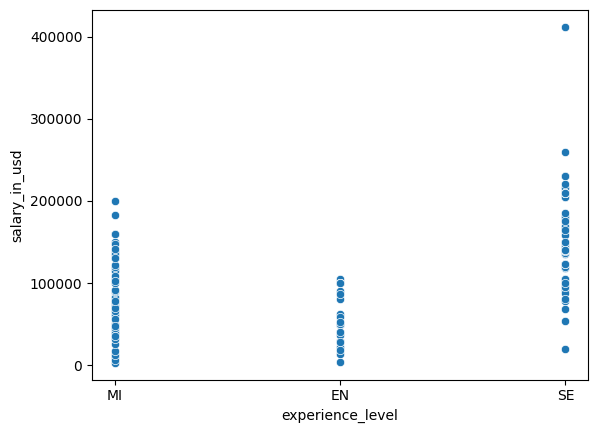

In [55]:
sns.scatterplot(data=data_about_DS,x='experience_level',y='salary_in_usd')

<Axes: xlabel='experience_level', ylabel='salary_in_usd'>

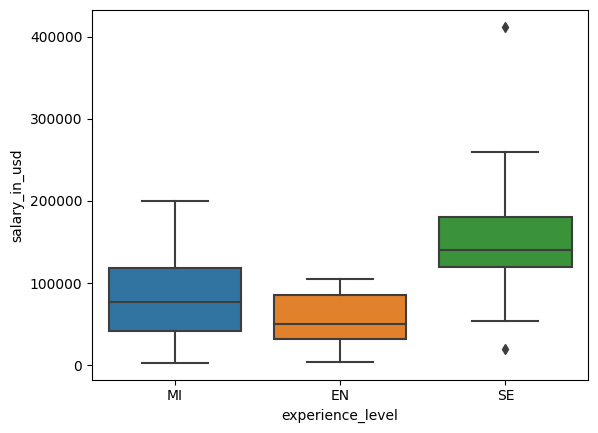

In [56]:
sns.boxplot(data=data_about_DS,x='experience_level',y='salary_in_usd')

Очевидно, что присутствует прямая линейная зависимость между опытом и ЗП)) (чем больше опыт,тем больше ЗП)

<Axes: xlabel='employment_type', ylabel='salary_in_usd'>

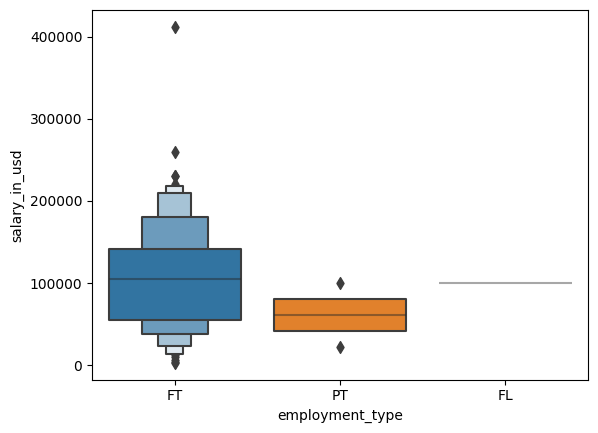

In [58]:
sns.boxenplot(data=data_about_DS,x='employment_type',y='salary_in_usd')

По этим коробкам с усами можно понять, что большинство DS-ов работаеют на фул тайме.

# Выясним различия в ЗП между Дата сайнтистами и дата инженерами!

Нулевая гипотеза = в среднем ЗП ДС меньше или равно ЗП ДИ.

Признаки независимы + кол-во признаков =2 + нужно проверить равенство дисперсий! 

In [59]:
data_about_DE=data[data['job_title']=='Data Engineer']

In [61]:
salary_DS=data_about_DS['salary_in_usd']
salary_DE=data_about_DE['salary_in_usd']
# проводим тест Левена на равенство дисперсий
print('Тест на равенство дисперсий')
result = stats.levene(salary_DS, salary_DE)
p = result[1]
print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.')
else:
    print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.')

# проводим тест на сравнение средних в группах
print('\nТест на равенство средних')
_, p = stats.ttest_ind(salary_DS, salary_DE, alternative='greater', equal_var=True)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))


Тест на равенство дисперсий
p-value = 0.342
Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.

Тест на равенство средних
p-value = 0.731
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


# ЗП дата-инженеров оказалась в среднем больше, чем у дата-сайнтистов

Чтобы ответить на вопрос о связи наличия должностей Data Scientist и Data Engineer и размером компании необходимо просто для компаний разной размерности посчитать кол-во должностей Data Scientist и Data Engineer, а также посчитать процент этих должностей от всего кол-ва.

In [19]:
DS_DE_for_S = data[(data['job_title']=='Data Scientist')&(data['company_size']=='S')].shape[0]+data[(data['job_title']=='Data Engineer')&(data['company_size']=='S')].shape[0]
DS_DE_for_M = data[(data['job_title']=='Data Scientist')&(data['company_size']=='M')].shape[0]+data[(data['job_title']=='Data Engineer')&(data['company_size']=='M')].shape[0]
DS_DE_for_L = data[(data['job_title']=='Data Scientist')&(data['company_size']=='L')].shape[0]+data[(data['job_title']=='Data Engineer')&(data['company_size']=='L')].shape[0]
print(DS_DE_for_S,DS_DE_for_M,DS_DE_for_L)
per_cent_for_S=DS_DE_for_S/data[data['company_size']=='S'].shape[0]
per_cent_for_M=DS_DE_for_S/data[data['company_size']=='M'].shape[0]
per_cent_for_L=DS_DE_for_S/data[data['company_size']=='L'].shape[0]
print(per_cent_for_S,per_cent_for_M,per_cent_for_L)

27 166 82
0.3253012048192771 0.08282208588957055 0.13636363636363635


Вывод (В среднем): 

Если компания маленькая, то в ней меньше всего (по кол-ву) должностей DS+DE, но по проценту топ-2. 

Если компания средняя по размеру, то в ней больше всего (и по кол-ву и по процентному сооношению) должностей DS+DE. 

Если компания большая, то по кол-ву должностей DS+DE она будет топ-2, а вот в процентном соотношении и вовсе топ 3.

Значит ни в плане кол-ва, ни в плане процентных соотношений, линейных зависимостей между рамером компании и кол-во или % должностей DS+DE нет!